## Выполнили: Никулина Евгения и Ступацкий Павел, группа БЭК181
### Данные по месячному производству пива в Австрии взяты из [kaggle](https://www.kaggle.com/shenba/time-series-datasets?select=monthly-beer-production-in-austr.csv)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import pmdarima as pm

from pylab import rcParams
rcParams['figure.figsize'] = (10, 5)

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('monthly-beer-production-in-austr.csv',  parse_dates=['Month'], index_col='Month')
df = df[:72]
df

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1961-08-01,87.1
1961-09-01,91.4
1961-10-01,109.9


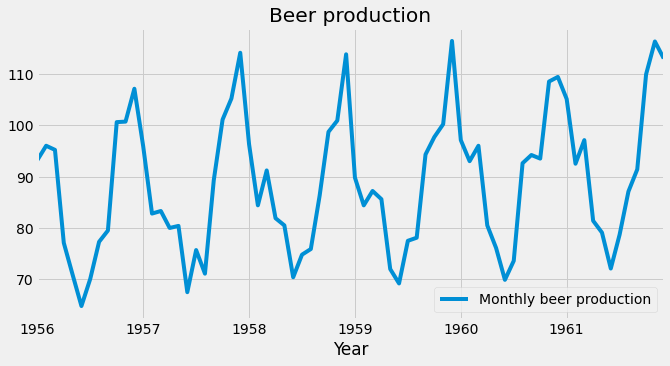

In [3]:
df.plot(xlabel='Year', title = 'Beer production');

### Автокорелляционные функции с лагами в 1 год и в 6 лет

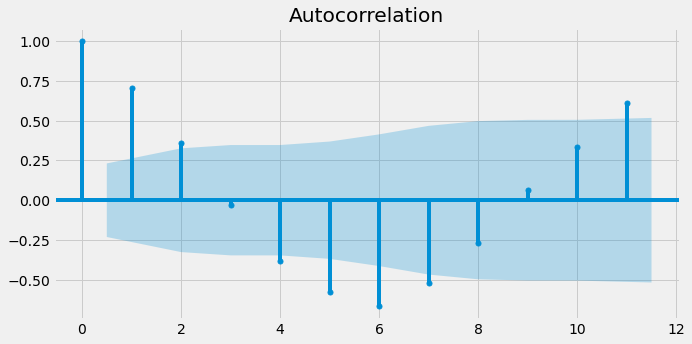

In [4]:
fig = tsaplots.plot_acf(df['Monthly beer production'], lags=11)
plt.show()

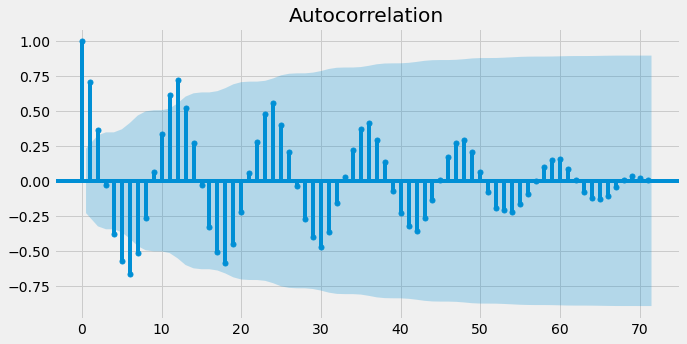

In [5]:
fig = tsaplots.plot_acf(df['Monthly beer production'], lags=71)
plt.show()

### График разложения временного ряда с помощью seasonal_decompose из пакета statsmodels показывает разбиение временного ряда на трендовые, сезонные и остаточные компоненты

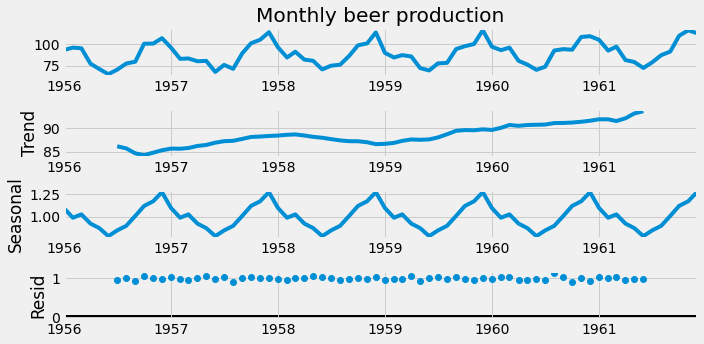

In [6]:
result = seasonal_decompose(df['Monthly beer production'], model='multiplicative')
result.plot()
plt.show()

## «Твиттер»
### Корреляция между $y_t$ и $y_{t-12}$ равна 0.75, что является достаточным показателем для того чтобы сказать что ряд сезонен. Так же есть возрастающий тренд, следовательно, ряд нельзя назвать стационарным, так как матожидание $y_t$ и $y_{t-120}$ не совпадает. Но, как ни странно, амплитуда колебаний не меняется во времени и равна приблизительно 45 у.е. литров пива между минимальным показателем в июне и пиком в ноябре-декабре

In [7]:
df_train = df[:60]
df_train.tail()

,Monthly beer production
Month,
1960-08-01,92.6
1960-09-01,94.2
1960-10-01,93.5
1960-11-01,108.5
1960-12-01,109.4


In [8]:
df_test = df[60:]
df_test

,Monthly beer production
Month,
1961-01-01,105.1
1961-02-01,92.5
1961-03-01,97.1
1961-04-01,81.4
1961-05-01,79.1
1961-06-01,72.1
1961-07-01,78.7
1961-08-01,87.1
1961-09-01,91.4


## Предсказываем

### 1. Наивный прогноз, $y_t = y_{t-1}$

In [9]:
y_t = df_train['Monthly beer production'][-1]
pred = df_test.copy()
pred['Monthly beer production'] = y_t
pred

,Monthly beer production
Month,
1961-01-01,109.4
1961-02-01,109.4
1961-03-01,109.4
1961-04-01,109.4
1961-05-01,109.4
1961-06-01,109.4
1961-07-01,109.4
1961-08-01,109.4
1961-09-01,109.4


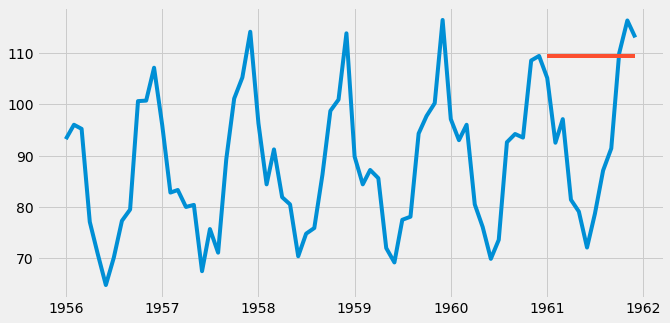

In [10]:
plt.plot(df['Monthly beer production'])
plt.plot(pred['Monthly beer production'])
plt.show()

In [11]:
print('Ошибка равна', mean_absolute_error(df_test, pred))

Ошибка равна 17.591666666666672


### 2. Наивный сезонный прогноз, $y_t = y_{t-12}$

In [12]:
y_t = df_train[['Monthly beer production']][-12:].to_numpy()
pred = df_test.copy()
pred['Monthly beer production'] = y_t
pred

,Monthly beer production
Month,
1961-01-01,97.1
1961-02-01,93.0
1961-03-01,96.0
1961-04-01,80.5
1961-05-01,76.1
1961-06-01,69.9
1961-07-01,73.6
1961-08-01,92.6
1961-09-01,94.2


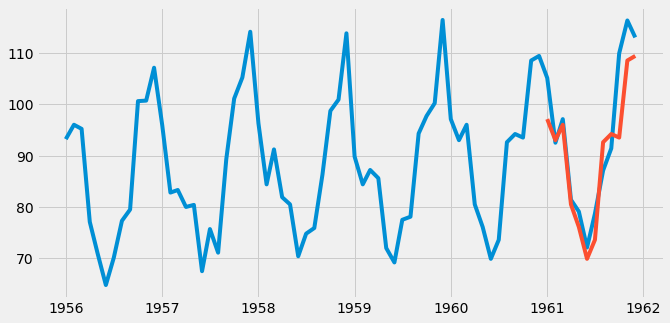

In [13]:
plt.plot(df['Monthly beer production'])
plt.plot(pred['Monthly beer production'])
plt.show()

In [14]:
print('Ошибка равна', mean_absolute_error(df_test, pred))

Ошибка равна 4.741666666666666


### 3. SARIMA(1,1,1)(1,0,0)[12]

In [15]:
param = [1,1,1]
param_seasonal = [1,0,0,12]
model = sm.tsa.statespace.SARIMAX(df_train,order=param,seasonal_order=param_seasonal,
                                enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()
results.aic # критерий Акаике

C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


300.91180072368604

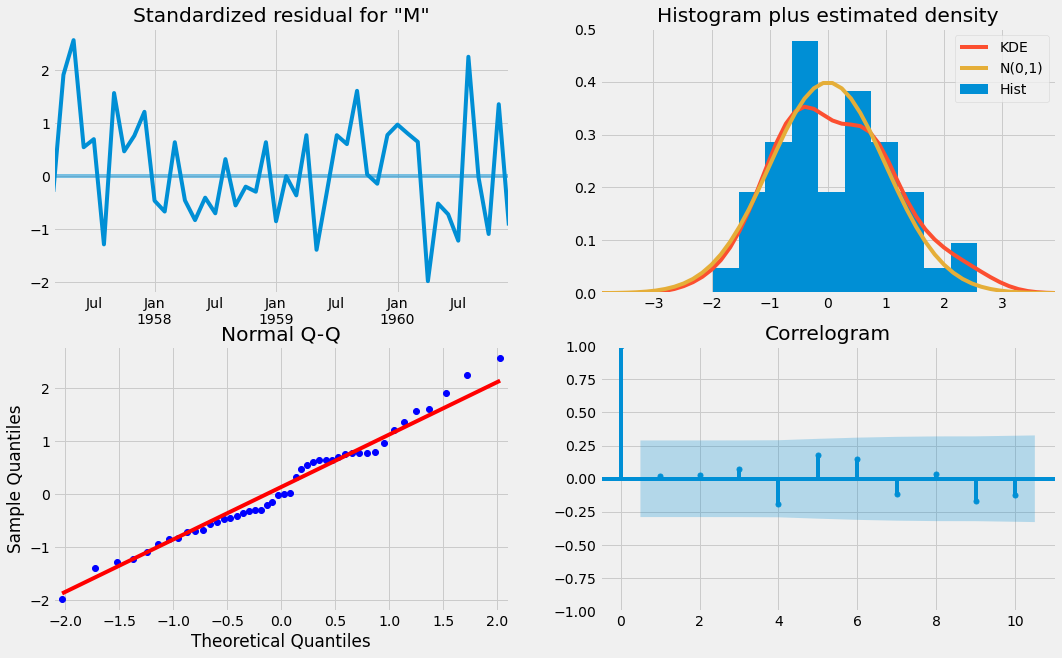

In [16]:
results.plot_diagnostics(figsize=(16, 10))
plt.show()

In [17]:
pred = results.forecast(steps=12)
pred

1961-01-01     98.842221
1961-02-01     93.958955
1961-03-01     96.848489
1961-04-01     83.252984
1961-05-01     79.420856
1961-06-01     74.002502
1961-07-01     77.235111
1961-08-01     93.832380
1961-09-01     95.230074
1961-10-01     94.618588
1961-11-01    107.721776
1961-12-01    108.507967
Freq: MS, Name: predicted_mean, dtype: float64

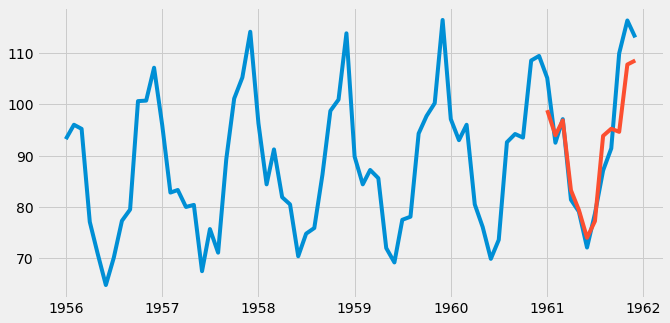

In [18]:
plt.plot(df['Monthly beer production'])
plt.plot(pred)
plt.show()

In [19]:
print('Ошибка равна', mean_absolute_error(df_test, pred)) # чуть меньше чем у наивной сезонной модели

Ошибка равна 4.368633315569706


### 4. Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA. Аналогично использованию autoArima - [источник](https://coderoad.ru/22770352/auto-arima-%D1%8D%D0%BA%D0%B2%D0%B8%D0%B2%D0%B0%D0%BB%D0%B5%D0%BD%D1%82-%D0%B4%D0%BB%D1%8F-python)

In [20]:
model = pm.auto_arima(df_train, seasonal=True, m=12)
forecasts = model.predict(df_test.shape[0])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   60
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -148.577
Date:                    Tue, 15 Jun 2021   AIC                            303.154
Time:                            19:28:32   BIC                            308.767
Sample:                                 0   HQIC                           305.275
                                     - 60                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9267      0.454      2.040      0.041       0.036       1.817
ma.S.L12      -0.6533      0.277     -2.356      0.018      -1.197      -0.110
sigma2        24.9595      5.703      4.377      0.000      13.783      36.136
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.34
Prob(Q):                              1.00   Prob(JB):                         0.84
Heteroskedasticity (H):               1.04   Skew:                            -0.02
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
pred = df_test.copy()
pred['Monthly beer production'] = forecasts
pred

,Monthly beer production
Month,
1961-01-01,96.842484
1961-02-01,90.720727
1961-03-01,93.594687
1961-04-01,83.746378
1961-05-01,78.040507
1961-06-01,71.176661
1961-07-01,76.838558
1961-08-01,84.180433
1961-09-01,92.928522


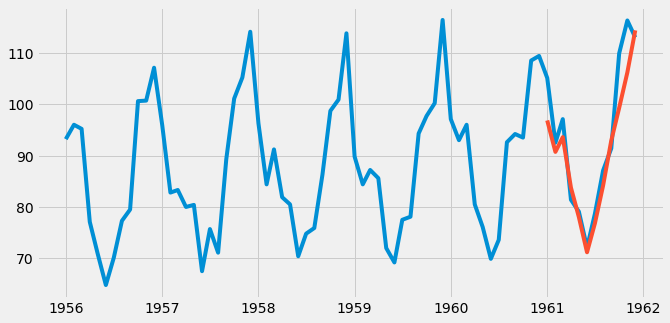

In [22]:
plt.plot(df['Monthly beer production'])
plt.plot(pred)
plt.show()

In [23]:
print('Ошибка равна', mean_absolute_error(df_test, pred)) # ошибка теперь ещё меньше!

Ошибка равна 3.8567200665576657


### 5. ETS(AAA) This is the Holt-Winter's triple exponential smoothing model

In [24]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.api import ExponentialSmoothing

In [25]:
model = ExponentialSmoothing(df_train['Monthly beer production'],seasonal_periods=12 ,trend='add', seasonal='add').fit()
pred = model.forecast(12)
pred

C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


1961-01-01     97.205041
1961-02-01     90.864949
1961-03-01     93.324874
1961-04-01     83.764994
1961-05-01     78.725051
1961-06-01     71.104966
1961-07-01     77.084973
1961-08-01     81.745077
1961-09-01     91.465003
1961-10-01    101.064997
1961-11-01    105.844969
1961-12-01    114.905010
Freq: MS, dtype: float64

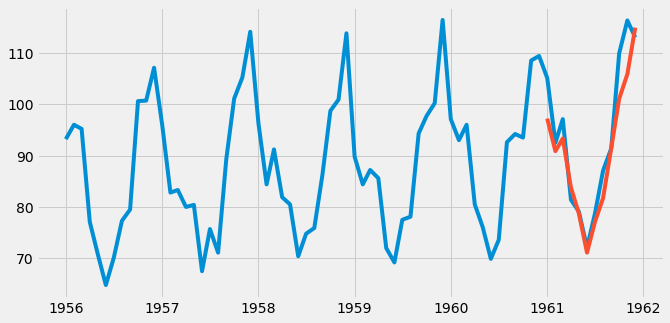

In [26]:
plt.plot(df['Monthly beer production'])
plt.plot(pred)
plt.show()

In [27]:
print('Ошибка равна', mean_absolute_error(df_test, pred)) # чуть уменьшилась

Ошибка равна 3.7725093727362555


### 6. ETS с автоматическим выбором по AIC

In [28]:
min_res = 250
best_i = 2.5
for i in np.linspace(-1, 2, num=13):
    model = ExponentialSmoothing(df_train['Monthly beer production'],seasonal_periods=12,
                                trend='add', seasonal='add').fit(smoothing_level=i)
    if model.aic < min_res:
        min_res = model.aic
        best_i = i
print(min_res, best_i)

C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\pavel\anaconda3\lib\site

196.0574399989039 0.0


C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [29]:
model = ExponentialSmoothing(df_train['Monthly beer production'],seasonal_periods=12,
                                trend='add', seasonal='add').fit(smoothing_level=best_i)
pred = model.forecast(12)
pred

C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


1961-01-01     97.204999
1961-02-01     90.865000
1961-03-01     93.324998
1961-04-01     83.765001
1961-05-01     78.724996
1961-06-01     71.105000
1961-07-01     77.085001
1961-08-01     81.744998
1961-09-01     91.465000
1961-10-01    101.065000
1961-11-01    105.845000
1961-12-01    114.904999
Freq: MS, dtype: float64

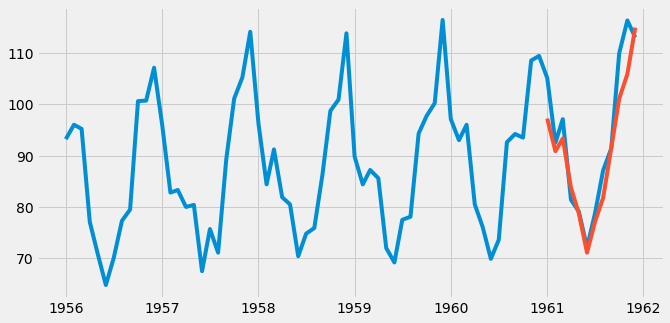

In [30]:
plt.plot(df['Monthly beer production'])
plt.plot(pred)
plt.show()

In [31]:
print('Ошибка равна', mean_absolute_error(df_test, pred)) # тот же самый результат

Ошибка равна 3.7725006956740166


## Итак, наилучшая модель ETS(AAA) с MAE = 3.77

In [32]:
df_train = df

In [33]:
model = ExponentialSmoothing(df_train['Monthly beer production'],seasonal_periods=12 ,trend='add', seasonal='add').fit()
pred = model.forecast(12)
pred

C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\pavel\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


1962-01-01    100.960868
1962-02-01     93.577472
1962-03-01     96.393846
1962-04-01     85.811064
1962-05-01     81.227255
1962-06-01     73.711294
1962-07-01     79.794088
1962-08-01     85.077573
1962-09-01     93.894012
1962-10-01    104.977634
1962-11-01    110.027573
1962-12-01    117.027369
Freq: MS, dtype: float64

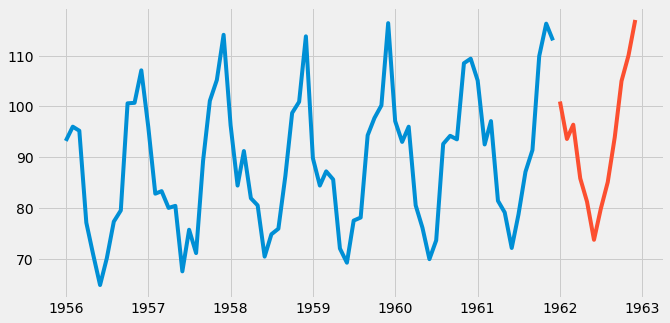

In [34]:
plt.plot(df['Monthly beer production'])
plt.plot(pred)
plt.show()

## «Хождение в народ»

In [35]:
import linearmodels as lm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

In [36]:
df = pd.read_csv('panel_data.csv')

In [37]:
df

,idind,year,heart,income
0,1,1994,NaN,160000.0
1,2,1994,NaN,600000.0
2,3,1994,NaN,1200000.0
3,4,1994,NaN,39000.0
4,5,1994,NaN,NaN
...,...,...,...,...
371883,59409,2019,1.0,NaN
371884,59410,2019,0.0,29000.0
371885,59411,2019,1.0,NaN
371886,59412,2019,0.0,NaN


## «Кому на Руси жить хорошо?»
### Вопрос: Помогает ли наличие хронических заболеваний сердца предсказывать индивидуальный доход?
## «Сделай красиво!»
Данные по сердечным заболеваниям собраны лишь для годов не ранее 2000. Из-за того, что предиктор дамми я использую bar plots.

In [38]:
heartinc = []
noheartinc = []
for i in range(2000, 2019):
    heartinc += [df[df['year'] == i][df['heart'] == 1]['income'].mean()]
    noheartinc += [df[df['year'] == i][df['heart'] == 0]['income'].mean()]

<ipython-input-38-196efb8b873a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  heartinc += [df[df['year'] == i][df['heart'] == 1]['income'].mean()]
<ipython-input-38-196efb8b873a>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noheartinc += [df[df['year'] == i][df['heart'] == 0]['income'].mean()]
<ipython-input-38-196efb8b873a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  heartinc += [df[df['year'] == i][df['heart'] == 1]['income'].mean()]
<ipython-input-38-196efb8b873a>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  noheartinc += [df[df['year'] == i][df['heart'] == 0]['income'].mean()]
<ipython-input-38-196efb8b873a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  heartinc += [df[df['year'] == i][df['heart'] == 1]['income'].mean()]
<ipython-input-38-196efb8b873a>:5: UserWarning: Boolean Series key will be reindexed t

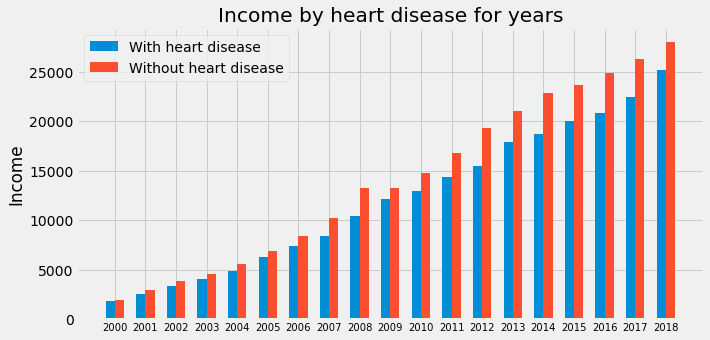

In [39]:
years = range(2000, 2019)

x = np.arange(len(years))
fig, ax = plt.subplots()
width = 0.3

bar1 = ax.bar(x - width/2, heartinc, width, label='With heart disease')
bar2 = ax.bar(x + width/2, noheartinc, width, label='Without heart disease')

ax.set_ylabel('Income')
ax.set_title('Income by heart disease for years')
ax.set_xticks(x)
ax.set_xticklabels(years, size=10)
ax.legend()

plt.show()

Похоже на то, что люди без заболеваний сердца имеют в среднем более высокую зарплату, чем люди с заболеваниями.

## «Три сестры»

In [40]:
df = df.set_index(['idind', 'year'])

In [41]:
df['const'] = 1
indep = ['const', 'heart']

### Pooled

In [42]:
Pooled = lm.PooledOLS(df['income'], df[indep]).fit(cov_type = 'clustered', cluster_entity = True)
print(Pooled)

C:\Users\pavel\AppData\Roaming\Python\Python38\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PooledOLS Estimation Summary                          
Dep. Variable:                 income   R-squared:                        0.0031
Estimator:                  PooledOLS   R-squared (Between):              0.0061
No. Observations:              133083   R-squared (Within):              -0.0045
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0031
Time:                        19:28:37   Log-likelihood                -1.486e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      410.26
Entities:                       26898   P-value                           0.0000
Avg Obs:                       4.9477   Distribution:                F(1,133081)
Min Obs:                       1.0000                                           
Max Obs:                       20.000   F-statistic (robust):             177.51
                            

### FE

In [43]:
Fixed = lm.PanelOLS(df['income'], df[indep], entity_effects=True).fit()
print(Fixed)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 income   R-squared:                     3.793e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0010
No. Observations:              133083   R-squared (Within):            3.793e-05
Date:                Tue, Jun 15 2021   R-squared (Overall):             -0.0006
Time:                        19:28:39   Log-likelihood                -1.414e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.0274
Entities:                       26898   P-value                           0.0448
Avg Obs:                       4.9477   Distribution:                F(1,106184)
Min Obs:                       1.0000                                           
Max Obs:                       20.000   F-statistic (robust):             4.0274
                            

### F-тест значимости индивидуальных эффектов в конце свидетельствует о том, что FE модель лучше сквозной.

### RE

In [44]:
Random = lm.RandomEffects(df['income'], df[indep]).fit()
print(Random)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 income   R-squared:                        0.0259
Estimator:              RandomEffects   R-squared (Between):              0.0015
No. Observations:              133083   R-squared (Within):              -0.0003
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0010
Time:                        19:28:40   Log-likelihood                -1.429e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3539.4
Entities:                       26898   P-value                           0.0000
Avg Obs:                       4.9477   Distribution:                F(1,133081)
Min Obs:                       1.0000                                           
Max Obs:                       20.000   F-statistic (robust):             15.448
                            

In [45]:
df = df.dropna()

In [46]:
df['resid'] = Pooled.resids
het_breuschpagan(df['resid'], df[indep])

(6.772168224045568, 0.0092590280366676, 6.772411076783744, 0.00925879410511455)

### p-values достаточно низкие, чтобы отвергнуть гипотезу о том что остатки не зависят от предикторов. Есть гетероскедастичность, значит RE лучше сквозной модели.

Я не нашел Хаусмана в готовых пакетах, поэтому взял функцию [отсюда](https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py):

In [47]:
import numpy.linalg as la
def hausman(fe, re):
    """
    Compute hausman test for fixed effects/random effects models
    b = beta_fe
    B = beta_re
    From theory we have that b is always consistent, but B is consistent
    under the alternative hypothesis and efficient under the null.
    The test statistic is computed as
    z = (b - B)' [V_b - v_B^{-1}](b - B)
    The statistic is distributed z \sim \chi^2(k), where k is the number
    of regressors in the model.
    Parameters
    ==========
    fe : statsmodels.regression.linear_panel.PanelLMWithinResults
        The results obtained by using sm.PanelLM with the
        method='within' option.
    re : statsmodels.regression.linear_panel.PanelLMRandomResults
        The results obtained by using sm.PanelLM with the
        method='swar' option.
    Returns
    =======
    chi2 : float
        The test statistic
    df : int
        The number of degrees of freedom for the distribution of the
        test statistic
    pval : float
        The p-value associated with the null hypothesis
    Notes
    =====
    The null hypothesis supports the claim that the random effects
    estimator is "better". If we reject this hypothesis it is the same
    as saying we should be using fixed effects because there are
    systematic differences in the coefficients.
    """

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov

    # NOTE: find df. fe should toss time-invariant variables, but it
    #       doesn't. It does return garbage so we use that to filter
    df = b[np.abs(b) < 1e8].size

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)

    return chi2, df, pval

In [48]:
hausman(Fixed, Random)

(202.15891464013612, 2, 1.2640069216137864e-44)

### Судя по тому, что p-value очень маленькая, мы отвергаем нулевую гипотезу об отсутствии эндогенности, а значит FE модель предпочтительна.

## «Ответ на главный вопрос»
В FE модели $R^2$ очень небольшой, p-value для гипотезы о незначимости коэффициентов <5%, но >1%. Наличие хронических заболеваний сердца практически не помогает предсказывать индивидуальный доход.